The key components of our Genetive Framework:
1. BERT: how to extract BERT embedding for a utterance.
2. GPT-2: how to predict stragegy for a utterance.
3. TP3M: how to do latent personality pridiction.
4. GRaSP: how to discovery the causal relationship among the strategies.
5. RB model: how to select the counterfactual action for BiCoGAN/KQR.
6. BiCoGAN: how to generate the counterfactual data.
7. KQR: how to generate the counterfactual data.
8. D3QN: how to select the optimal action.
9. Cumulative reward.

In [1]:
from transformers import BertTokenizer, BertModel
import torch
import pandas as pd
import numpy as np

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

2025-03-11 00:52:08.907386: E tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:9342] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2025-03-11 00:52:08.907430: E tensorflow/compiler/xla/stream_executor/cuda/cuda_fft.cc:609] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2025-03-11 00:52:08.907449: E tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:1518] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-03-11 00:52:08.911898: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-03-11 00:52:09.449719: W tensorflow/compiler/

## 0. Preprocessing

In [2]:
df_loaded = pd.read_csv('postdata/example_dialogue.csv', index_col=False)
info_loaded = pd.read_csv('postdata/example_info.csv', index_col=False)

df_loaded["_group"] = (df_loaded["B4"] != df_loaded["B4"].shift()).cumsum()
 
df_loaded = df_loaded.groupby("_group").agg({
    "B2": "first",
    "B4": "first",
    "Turn": "first",
    "Unit": lambda x: " ".join(x.dropna()),   
    "er_label_1": lambda x: ", ".join(x.dropna().astype(str)),
    "ee_label_1": lambda x: ", ".join(x.dropna().astype(str)),
}).reset_index(drop=True)

df_loaded


,B2,B4,Turn,Unit,er_label_1,ee_label_1
0,20180719-210146_172_live,0,0,Hello. How are you?,"greeting, greeting",
1,20180719-210146_172_live,1,0,"I'm good, how are you doing?",,greeting
2,20180719-210146_172_live,0,1,Very well. I'm just up organizing info for my ...,"greeting, other, task-related-inquiry",
3,20180719-210146_172_live,1,1,Yes! I work with children who have terminal il...,,"positive-to-inquiry, positive-to-inquiry, task..."
4,20180719-210146_172_live,0,2,That's great! I help with Save The Children.,"acknowledgement, neutral-to-inquiry",
5,20180719-210146_172_live,1,2,Amazing! Working with kids is the best. What d...,,"acknowledgement, positive-reaction-to-donation..."
6,20180719-210146_172_live,0,3,I help raise donations and volunteer time.,neutral-to-inquiry,
7,20180719-210146_172_live,1,3,That's so important. How do you raise donations?,,"acknowledgement, task-related-inquiry"
8,20180719-210146_172_live,0,4,By directly asking for aid. Do you currently d...,"neutral-to-inquiry, task-related-inquiry",
9,20180719-210146_172_live,1,4,"Yes I do, but I'm happy to donate to yours as ...",,agree-donation


## 1. BERT: how to extract BERT embedding for a utterance.

In [3]:
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
bert_model = BertModel.from_pretrained('bert-base-uncased')

def get_bert_embedding(text):
    inputs = tokenizer(text, return_tensors='pt', truncation=True, padding=True)
    with torch.no_grad():
        outputs = bert_model(**inputs)
    return outputs.last_hidden_state.mean(dim=1).squeeze().numpy()

df_loaded["BERT"] = df_loaded["Unit"].apply(get_bert_embedding)
df_loaded


,B2,B4,Turn,Unit,er_label_1,ee_label_1,BERT
0,20180719-210146_172_live,0,0,Hello. How are you?,"greeting, greeting",,"[0.000704363, -0.5587156, 0.08349371, -0.36704..."
1,20180719-210146_172_live,1,0,"I'm good, how are you doing?",,greeting,"[0.263212, -0.40168962, -0.12734856, -0.181838..."
2,20180719-210146_172_live,0,1,Very well. I'm just up organizing info for my ...,"greeting, other, task-related-inquiry",,"[0.40762126, -0.1540149, 0.21940741, 0.0368090..."
3,20180719-210146_172_live,1,1,Yes! I work with children who have terminal il...,,"positive-to-inquiry, positive-to-inquiry, task...","[0.20153412, -0.1693443, -0.061898034, -0.2116..."
4,20180719-210146_172_live,0,2,That's great! I help with Save The Children.,"acknowledgement, neutral-to-inquiry",,"[0.24622099, 0.2640231, 0.1742113, -0.10790341..."
5,20180719-210146_172_live,1,2,Amazing! Working with kids is the best. What d...,,"acknowledgement, positive-reaction-to-donation...","[0.16306667, -0.090926036, 0.0016495853, -0.04..."
6,20180719-210146_172_live,0,3,I help raise donations and volunteer time.,neutral-to-inquiry,,"[0.42490134, 0.29470462, -0.123737715, 0.10192..."
7,20180719-210146_172_live,1,3,That's so important. How do you raise donations?,,"acknowledgement, task-related-inquiry","[0.35323712, -0.020239891, -0.0911983, 0.10451..."
8,20180719-210146_172_live,0,4,By directly asking for aid. Do you currently d...,"neutral-to-inquiry, task-related-inquiry",,"[0.5082475, -0.14692014, 0.064636, -0.02670014..."
9,20180719-210146_172_live,1,4,"Yes I do, but I'm happy to donate to yours as ...",,agree-donation,"[0.3501961, 0.14631529, 0.25062004, 0.02447924..."


## 2. GPT-2: how to predict stragegy for a utterance.

In [4]:
import gpt2


df_loaded[['stg_pred', 'logits']] = df_loaded.apply(
    lambda row: gpt2.USP_er_pred(row['Unit']) if row['B4'] == 0 else gpt2.USP_ee_pred(row['Unit']),
    axis=1,
    result_type='expand'  
)

df_loaded


,B2,B4,Turn,Unit,er_label_1,ee_label_1,BERT,stg_pred,logits
0,20180719-210146_172_live,0,0,Hello. How are you?,"greeting, greeting",,"[0.000704363, -0.5587156, 0.08349371, -0.36704...",greeting,"[18.382606506347656, -0.39407220482826233, -0...."
1,20180719-210146_172_live,1,0,"I'm good, how are you doing?",,greeting,"[0.263212, -0.40168962, -0.12734856, -0.181838...",greeting,"[18.828256607055664, 0.15999004244804382, -5.2..."
2,20180719-210146_172_live,0,1,Very well. I'm just up organizing info for my ...,"greeting, other, task-related-inquiry",,"[0.40762126, -0.1540149, 0.21940741, 0.0368090...",task-related-inquiry,"[7.597187519073486, 3.7180490493774414, 10.178..."
3,20180719-210146_172_live,1,1,Yes! I work with children who have terminal il...,,"positive-to-inquiry, positive-to-inquiry, task...","[0.20153412, -0.1693443, -0.061898034, -0.2116...",task-related-inquiry,"[-1.5145589113235474, 5.0962419509887695, 12.9..."
4,20180719-210146_172_live,0,2,That's great! I help with Save The Children.,"acknowledgement, neutral-to-inquiry",,"[0.24622099, 0.2640231, 0.1742113, -0.10790341...",credibility-appeal,"[-2.4126579761505127, -3.4065041542053223, 0.3..."
5,20180719-210146_172_live,1,2,Amazing! Working with kids is the best. What d...,,"acknowledgement, positive-reaction-to-donation...","[0.16306667, -0.090926036, 0.0016495853, -0.04...",task-related-inquiry,"[-0.0715700164437294, 0.33111488819122314, 9.9..."
6,20180719-210146_172_live,0,3,I help raise donations and volunteer time.,neutral-to-inquiry,,"[0.42490134, 0.29470462, -0.123737715, 0.10192...",neutral-to-inquiry,"[-0.7010234594345093, 3.5734541416168213, -1.2..."
7,20180719-210146_172_live,1,3,That's so important. How do you raise donations?,,"acknowledgement, task-related-inquiry","[0.35323712, -0.020239891, -0.0911983, 0.10451...",task-related-inquiry,"[-1.074475646018982, -0.8098622560501099, 11.6..."
8,20180719-210146_172_live,0,4,By directly asking for aid. Do you currently d...,"neutral-to-inquiry, task-related-inquiry",,"[0.5082475, -0.14692014, 0.064636, -0.02670014...",task-related-inquiry,"[0.49757981300354004, -2.1116578578948975, 14...."
9,20180719-210146_172_live,1,4,"Yes I do, but I'm happy to donate to yours as ...",,agree-donation,"[0.3501961, 0.14631529, 0.25062004, 0.02447924...",agree-donation,"[-1.6835048198699951, 2.381093740463257, -2.65..."


## 3. TP3M: how to do latent personality pridiction.

In [6]:
import torch
import torch.nn as nn

class TransformerRegression(nn.Module):
    def __init__(self, input_dim, output_dim, num_heads, num_layers, hidden_dim):
        super(TransformerRegression, self).__init__()
        self.bn = nn.BatchNorm1d(input_dim).to(device)
        self.lstm = nn.LSTM(input_dim, hidden_dim, num_layers, batch_first=True).to(device)

        self.transformer = nn.TransformerEncoder(
            nn.TransformerEncoderLayer(d_model=input_dim, nhead=num_heads, dim_feedforward=hidden_dim),
            num_layers=num_layers).to(device)
        self.fc1 = nn.Linear(input_dim, hidden_dim).to(device)
        self.fc2 = nn.Linear(hidden_dim, output_dim).to(device)

    def forward(self, x):
        x = self.bn(x)
        x = self.transformer(x)
        x = self.fc1(x)
        x = self.fc2(x)
        return x
    

input_dim = 768
output_dim = 5
num_heads = 16
num_layers = 4
hidden_dim = 1024

tp3m_model = TransformerRegression(input_dim, output_dim, num_heads, num_layers, hidden_dim)
tp3m_model = torch.load('trained_models/T3P_model.pt')

state_action_example_i = "".join(df_loaded["Unit"].iloc[1]+df_loaded["Unit"].iloc[2])
print(state_action_example_i)

one_turn = torch.tensor(get_bert_embedding(state_action_example_i)).unsqueeze(0)
pred_personality_ee = tp3m_model(one_turn.to(device))
pred_personality_ee


I'm good, how are you doing?Very well. I'm just up organizing info for my charity. Are you involved with charities?


tensor([[3.0998, 3.5331, 3.2664, 2.0230, 3.0994]], device='cuda:0',
       grad_fn=<AddmmBackward0>)

## 4. GRaSP: how to discovery the causal relationship among the strategies.

In [49]:
ee_label_list = ["EE_"+item for item in open("postdata/EE_stg_index.txt", "r").read().splitlines()]  # 23 labels
er_label_list = ["ER_"+item for item in open("postdata/ER_stg_index.txt", "r").read().splitlines()]  # 27 labels


def expand_logits(row):
    """Expand logits into separate columns based on B4 value."""
    if row["B4"] == 1:
        return pd.Series(row["logits"], index=ee_label_list)
    else:
        return pd.Series(row["logits"], index=er_label_list)

stg_df = df_loaded.apply(expand_logits, axis=1)
stg_df.fillna(stg_df.mean(), inplace=True)

stg_df


,EE_acknowledgement,EE_agree-donation,EE_ask-donation-procedure,EE_ask-org-info,EE_ask-persuader-donation-intention,EE_closing,EE_confirm-donation,EE_disagree-donation,EE_disagree-donation-more,EE_greeting,...,ER_personal-related-inquiry,ER_personal-story,ER_positive-to-inquiry,ER_praise-user,ER_proposition-of-donation,ER_self-modeling,ER_source-related-inquiry,ER_task-related-inquiry,ER_thank,ER_you-are-welcome
0,-2.797022,4.141757,0.669881,-0.405505,-0.081494,-2.018652,2.243441,0.505230,0.045763,0.181036,...,2.015196,-4.032898,0.592851,-0.146831,-4.908338,-5.454237,2.448351,-0.646275,-1.577994,1.271008
1,-3.939708,-0.248487,4.367686,2.737585,1.129993,2.246693,2.263277,0.767582,0.633946,18.828257,...,-0.492844,-0.784729,-0.619380,-0.522142,2.034115,-2.057214,-0.541241,2.640584,1.986358,-3.112741
2,-2.797022,4.141757,0.669881,-0.405505,-0.081494,-2.018652,2.243441,0.505230,0.045763,0.181036,...,8.241144,-3.715698,-3.355795,-4.422628,2.091186,-3.660766,3.760238,10.178200,-0.715705,-2.371731
3,-2.788457,-1.099740,-0.004312,1.644476,2.195041,-1.604302,-2.614119,-5.530531,-0.340134,-1.514559,...,-0.492844,-0.784729,-0.619380,-0.522142,2.034115,-2.057214,-0.541241,2.640584,1.986358,-3.112741
4,-2.797022,4.141757,0.669881,-0.405505,-0.081494,-2.018652,2.243441,0.505230,0.045763,0.181036,...,-6.004375,5.459974,4.122430,2.545265,-1.005331,-3.149477,2.140091,0.332398,4.018996,-3.004231
5,-2.058380,-1.985007,4.132051,0.093121,4.781309,-0.055872,-3.265484,-4.872552,0.480923,-0.071570,...,-0.492844,-0.784729,-0.619380,-0.522142,2.034115,-2.057214,-0.541241,2.640584,1.986358,-3.112741
6,-2.797022,4.141757,0.669881,-0.405505,-0.081494,-2.018652,2.243441,0.505230,0.045763,0.181036,...,1.634422,4.892591,4.762448,-2.508769,-2.374851,6.765120,-3.973975,-1.200472,-5.750365,-1.948646
7,-1.205378,-0.849306,5.506648,-0.329285,5.105749,-1.658738,-3.386348,-4.647981,0.590684,-1.074476,...,-0.492844,-0.784729,-0.619380,-0.522142,2.034115,-2.057214,-0.541241,2.640584,1.986358,-3.112741
8,-2.797022,4.141757,0.669881,-0.405505,-0.081494,-2.018652,2.243441,0.505230,0.045763,0.181036,...,7.675565,-2.294550,2.459230,-2.045296,3.078309,-4.710995,2.205862,14.000738,-1.642487,-1.957748
9,-5.533055,12.527321,-1.549136,-2.814013,0.566785,-2.252808,2.060070,3.791265,1.917854,-1.683505,...,-0.492844,-0.784729,-0.619380,-0.522142,2.034115,-2.057214,-0.541241,2.640584,1.986358,-3.112741


GRaSP edge count: 424    
GRaSP completed in: 394.31s 


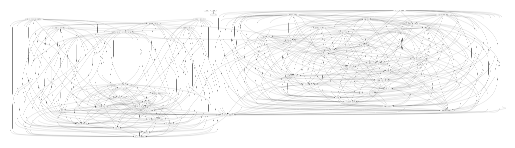

In [65]:
# GRaSP
from causallearn.search.PermutationBased.GRaSP import grasp
from causallearn.utils.GraphUtils import GraphUtils
import io

import matplotlib.pyplot as plt
import matplotlib.image as mpimg

#instead of use the stg_df, we plan to use our data since the example stg_df is too small and cannot find good causal relationship.
_df = pd.read_csv("postdata/uttr_stg_prob.csv", index_col=0)

Record = grasp(_df.to_numpy().astype(np.float16), score_func="local_score_BIC")
pyd = GraphUtils.to_pydot(Record, labels=list(_df.columns))  

tmp_png = pyd.create_png(f="png")
fp = io.BytesIO(tmp_png)
img = mpimg.imread(fp, format='png')
plt.axis('off')
plt.imshow(img)
plt.show()
pyd.write_png("causal_graph/umap_code.png")
pyd.write_png("causal_graph/umap_code.png")


In [73]:
with open("postdata/causal_pairs.txt", "w") as file:
    for edge in pyd.get_edges():
        source = edge.get_source()  # Get the source node (A), cause
        destination = edge.get_destination()  # Get the destination node (B), effect
        
        file.write(f"{list(stg_df.columns)[source]} --> {list(stg_df.columns)[destination]}\n")

## 5. RB model: how to select the counterfactual action for BiCoGAN/KQR.

In [74]:
causal_pairs_df = pd.read_csv("postdata/causal_pairs.txt", sep=" --> ", header=None, names=["cause", "effect"])

causal_pairs_df


/tmp/ipykernel_1039363/2155731637.py:1: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  causal_pairs_df = pd.read_csv("causal_pairs.txt", sep=" --> ", header=None, names=["cause", "effect"])


,cause,effect
0,ee_greeting,er_logical-appeal
1,ee_positive-to-inquiry,er_logical-appeal
2,ee_positive-to-inquiry,er_personal-related-inquiry
3,ee_positive-to-inquiry,er_closing
4,ee_task-related-inquiry,er_logical-appeal
5,ee_task-related-inquiry,er_personal-related-inquiry
6,ee_task-related-inquiry,er_closing
7,ee_acknowledgement,er_logical-appeal
8,ee_acknowledgement,er_personal-related-inquiry
9,ee_acknowledgement,er_closing


In [117]:
# Example

update_df = df_loaded[["B2", "B4", "Unit", "stg_pred"]]

counter_df = pd.DataFrame(columns=["state", "action", "next_state", "state_stg", "action_stg", "next_state_stg"])

# 1. If the first `B4` is 0, add a row with "hello" and "greeting"
if update_df["B4"].iloc[0] == 0:
    new_row = pd.DataFrame({
        "state": ["hello"],
        "action": [update_df["Unit"].iloc[0]],  # Action is the first 'Unit'
        "next_state": [update_df["Unit"].iloc[1]],  # Next state will be the next 'Unit'
        "state_pred_stg": ["greeting"],
        "action_pred_stg": [update_df["stg_pred"].iloc[0]],  # Strategy for the action
        "next_state_stg": [update_df["stg_pred"].iloc[1]]  # Strategy for the next state
    })
    counter_df = pd.concat([new_row, counter_df], ignore_index=True)

# 2. Iterate through `update_df` and populate `kl_df` for state, action, next_state, and their respective strategies
for i in range(1, len(update_df) - 1):  # Start from 1 to avoid first action row
    if update_df["B4"].iloc[i] == 1:
        state = update_df["Unit"].iloc[i]  # State for B4 == 1
        action = update_df["Unit"].iloc[i-1]  # Action will be the previous row where B4 == 0
        next_state = update_df["Unit"].iloc[i + 1]  # Next state for the next B4 == 1
        
        counter_df = pd.concat([counter_df, pd.DataFrame({
            "state": [state],
            "action": [action],
            "next_state": [next_state],
            "state_pred_stg": [update_df["stg_pred"].iloc[i]],
            "action_pred_stg": [update_df["stg_pred"].iloc[i-1]],
            "next_state_stg": [update_df["stg_pred"].iloc[i + 1]]
        })], ignore_index=True)




def get_effects_stg(df, ee_stg):
    _df = df[df["cause"]=="ee_"+ee_stg]
    return _df[_df["effect"].str.startswith('er_')]["effect"].tolist()

counter_df["counter_action_stg"] = counter_df["state_pred_stg"].apply(lambda stg: get_effects_stg(causal_pairs_df, stg))
counter_df


,state,action,next_state,state_pred_stg,action_pred_stg,next_state_stg,state_stg,action_stg,counter_action_stg
0,hello,Hello. How are you?,"I'm good, how are you doing?",greeting,greeting,greeting,NaN,NaN,[er_logical-appeal]
1,"I'm good, how are you doing?",Hello. How are you?,Very well. I'm just up organizing info for my ...,greeting,greeting,task-related-inquiry,NaN,NaN,[er_logical-appeal]
2,Yes! I work with children who have terminal il...,Very well. I'm just up organizing info for my ...,That's great! I help with Save The Children.,task-related-inquiry,task-related-inquiry,credibility-appeal,NaN,NaN,"[er_logical-appeal, er_personal-related-inquir..."
3,Amazing! Working with kids is the best. What d...,That's great! I help with Save The Children.,I help raise donations and volunteer time.,task-related-inquiry,credibility-appeal,neutral-to-inquiry,NaN,NaN,"[er_logical-appeal, er_personal-related-inquir..."
4,That's so important. How do you raise donations?,I help raise donations and volunteer time.,By directly asking for aid. Do you currently d...,task-related-inquiry,neutral-to-inquiry,task-related-inquiry,NaN,NaN,"[er_logical-appeal, er_personal-related-inquir..."
5,"Yes I do, but I'm happy to donate to yours as ...",By directly asking for aid. Do you currently d...,Wonderful! Would you be will to donate $1.00 o...,agree-donation,task-related-inquiry,credibility-appeal,NaN,NaN,[]
6,"Yes, I would be happy to!",Wonderful! Would you be will to donate $1.00 o...,Would $2.00 be too much to ask?,agree-donation,credibility-appeal,ask-donate-more,NaN,NaN,[]
7,"No, I can do it.",Would $2.00 be too much to ask?,Thank you. Can we make it $1.50? These childre...,agree-donation,ask-donate-more,thank,NaN,NaN,[]
8,$1.50 sounds good then.,Thank you. Can we make it $1.50? These childre...,Why not $1.75 then? :-),provide-donation-amount,thank,ask-donate-more,NaN,NaN,[]
9,I can do $2.00! Happy to help.,Why not $1.75 then? :-),Thank you so much! Do you have any more questi...,provide-donation-amount,ask-donate-more,thank,NaN,NaN,[]


In [ ]:
# Example

state = ['I\'m good, how are you doing?']  # Persuadee's State
action = ['Very well. I\'m just up organizing info for my charity. Are you involved with charities?']  # Persuader's Action
next_state = ['Yes! I work with children who have terminal illnesses. What charity are you involved in?']  # Persuadee's Next State
state_pred_stg=["greeting"]
action_pred_stg=["task-related-inquiry"]
next_state_stg=["positive-to-inquiry"] 

counter_df = pd.DataFrame({
    'state': state,
    'action': action,
    'next_state': next_state,
    'state_pred_stg': state_pred_stg,
    'action_pred_stg': action_pred_stg,
    'next_state_stg': next_state_stg,
})

def get_effects_stg(df, ee_stg):
    _df = df[df["cause"]=="ee_"+ee_stg]
    return _df[_df["effect"].str.startswith('er_')]["effect"].tolist()

counter_df["counter_action_stg"] = counter_df["state_pred_stg"].apply(lambda stg: get_effects_stg(causal_pairs_df, stg))
counter_df


In [125]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
import numpy as np

vectorizer = TfidfVectorizer()

def select_best_action_tf(state, actions):
    
    documents = [state] + actions
    tfidf_matrix = vectorizer.fit_transform(documents)

    state_vector = tfidf_matrix[0]
    action_vectors = tfidf_matrix[1:]
    similarities = cosine_similarity(state_vector, action_vectors).flatten()

    top_3_indices = np.argsort(similarities)[-3:]
    top_actions = [actions[i] for i in top_3_indices]

    return top_actions

def apply_selection(row):
    er_uttr_dict = counter_df.groupby('action_pred_stg')['action'].apply(list).to_dict()
    state = row["state"]
    state_counter_action_stg_list = row["counter_action_stg"]
    
    if len(state_counter_action_stg_list) == 0:
        actions = np.random.choice(counter_df["action"], size=50)
    else:
        actions = []
        for state_counter_action_stg in state_counter_action_stg_list:
            actions.extend(er_uttr_dict.get(state_counter_action_stg.replace("er_", ""), []))
        
        if not actions: 
            actions = np.random.choice(counter_df["action"], size=50)
    
    return select_best_action_tf(state, actions)



counter_df["counter_action_stg"] = counter_df.apply(lambda row: apply_selection(row), axis=1)
counter_df


,state,action,next_state,state_pred_stg,action_pred_stg,next_state_stg,state_stg,action_stg,counter_action_stg
0,hello,Hello. How are you?,"I'm good, how are you doing?",greeting,greeting,greeting,NaN,NaN,"[Hello. How are you?, why should i give you my..."
1,"I'm good, how are you doing?",Hello. How are you?,Very well. I'm just up organizing info for my ...,greeting,greeting,task-related-inquiry,NaN,NaN,"[Would $2.00 be too much to ask?, so you gonna..."
2,Yes! I work with children who have terminal il...,Very well. I'm just up organizing info for my ...,That's great! I help with Save The Children.,task-related-inquiry,task-related-inquiry,credibility-appeal,NaN,NaN,[Thank you so much! Do you have any more quest...
3,Amazing! Working with kids is the best. What d...,That's great! I help with Save The Children.,I help raise donations and volunteer time.,task-related-inquiry,credibility-appeal,neutral-to-inquiry,NaN,NaN,[Thank you. Can we make it $1.50? These childr...
4,That's so important. How do you raise donations?,I help raise donations and volunteer time.,By directly asking for aid. Do you currently d...,task-related-inquiry,neutral-to-inquiry,task-related-inquiry,NaN,NaN,[no you could use my info to do some sketchy c...
5,"Yes I do, but I'm happy to donate to yours as ...",By directly asking for aid. Do you currently d...,Wonderful! Would you be will to donate $1.00 o...,agree-donation,task-related-inquiry,credibility-appeal,NaN,NaN,"[why should i give you my mturk number? also, ..."
6,"Yes, I would be happy to!",Wonderful! Would you be will to donate $1.00 o...,Would $2.00 be too much to ask?,agree-donation,credibility-appeal,ask-donate-more,NaN,NaN,"[why should i give you my mturk number? also, ..."
7,"No, I can do it.",Would $2.00 be too much to ask?,Thank you. Can we make it $1.50? These childre...,agree-donation,ask-donate-more,thank,NaN,NaN,[Thank you. Can we make it $1.50? These childr...
8,$1.50 sounds good then.,Thank you. Can we make it $1.50? These childre...,Why not $1.75 then? :-),provide-donation-amount,thank,ask-donate-more,NaN,NaN,"[so you gonna donate or what, no you could use..."
9,I can do $2.00! Happy to help.,Why not $1.75 then? :-),Thank you so much! Do you have any more questi...,provide-donation-amount,ask-donate-more,thank,NaN,NaN,[Very well. I'm just up organizing info for my...


## 6. BiCoGAN: how to generate the counterfactual data.

In [1]:
import torch
import numpy as np
import BiCoGAN_base # release if the paper get accepted
import BiCoGAN_latent # release if the paper get accepted
from torch.nn.utils.rnn import pad_sequence
import torch.nn as nn

from utils_counterD import restructure_dialogue_padding

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

class RegressionModel(nn.Module):
    def __init__(self, input_dim, hidden_dim, num_layers):
        super(RegressionModel, self).__init__()

        self.rnn = nn.LSTM(input_size=input_dim, hidden_size=hidden_dim, num_layers=num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_dim, 1)

    def forward(self, x):
        lstm_out, _ = self.rnn(x)
        last_output = lstm_out[:, -1, :]  
        output = self.fc(last_output)
        return output
    
# TP3M_model = RegressionModel(768, 256, 2).to(device)
TP3M_model = torch.load('trained_models/TP3M.pt')  


2025-03-10 22:42:58.892407: E tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:9342] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2025-03-10 22:42:58.892435: E tensorflow/compiler/xla/stream_executor/cuda/cuda_fft.cc:609] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2025-03-10 22:42:58.892454: E tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:1518] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-03-10 22:42:58.896894: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-03-10 22:42:59.561995: W tensorflow/compiler/

In [3]:
# Generate counterfactual next state with (1) BiCoGAN base

n_dim = 768
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

cfg = {'general':  {'noise_size':n_dim, 'state_size':n_dim, 'hidden_size':100, 'type':'single', \
                    'condition_size':n_dim+n_dim},
       'gan_paras':{'lr_gan':1e-4, 'dis_cogan': True, 'layer_num':2}}
GC_est = np.hstack((np.diag([1]*n_dim), np.ones((n_dim, 1), dtype=int)))

LitCounter = BiCoGAN_base.LitCounter(GC_est, cfg)
LitCounter.load_state_dict(torch.load("trained_models/LitCounter_model.pt"))
LitCounter.eval()
LitCounter.to(device)
# t_counter_action is from RM model

N_dialog = 10
t_states = torch.tensor(np.random.rand(N_dialog*25, 768))
t_actions = torch.tensor(np.random.rand(N_dialog*25, 768))
t_counter_action = torch.tensor(np.random.rand(N_dialog*25, 768))
t_next_states = torch.tensor(np.random.rand(N_dialog*25, 768))
t_dones = np.array([[0]*24+[1]]*N_dialog).flatten().tolist()

t_counter_next_state = LitCounter.counterfactual(t_states.cpu(), t_counter_action.cpu(), t_next_states.cpu()).detach().cpu()
Best_counter_dialogue = restructure_dialogue_padding(t_dones, t_states.cpu().numpy(), t_counter_action.detach().numpy(), t_counter_next_state.detach().numpy())
Best_counter_dialogue.shape


(10, 25, 768)

In [14]:
t_actions = torch.tensor(np.random.rand(N_dialog*25, 768))


In [5]:
# Generate counterfactual next state with (2) Latent BiCoGAN


cfg_latent = {'general': {'noise_size':n_dim, 'state_size':n_dim, 'hidden_size':100, 'type':'single', \
                   'condition_size':n_dim+n_dim+5},
       'gan_paras':{'lr_gan':1e-4, 'dis_cogan': True, 'layer_num':2}}

GC_est_latent = np.hstack((np.diag([1]*n_dim), np.ones((n_dim, 1), dtype=int)))
LitCounter_latent = BiCoGAN_latent.LitCounter(GC_est_latent, cfg_latent)
LitCounter_latent.load_state_dict(torch.load("trained_models/LitCounter_lantent_model.pt"))
LitCounter_latent.eval()
LitCounter_latent.to(device)

# t_counter_action is from RM model
t_counter_next_state_latent= torch.tensor(np.random.rand(N_dialog*25, 5)) # TP3M prediction based on the input (t_states, t_counter_action)

t_counter_next_state_latent = LitCounter_latent.counterfactual(t_states.cpu(), t_counter_action.cpu(), t_next_states.cpu()).detach().cpu()
Best_counter_dialogue_latent = restructure_dialogue_padding(t_dones, t_states.cpu().numpy(), t_counter_action.detach().numpy(), t_counter_next_state_latent.detach().numpy())
Best_counter_dialogue_latent.shape


(10, 25, 768)

In [16]:
t_rewards_x = [0.5, 1.0, 1.5, 1.0, 1.5, 0.5, 0.0, 0.4, 0.7, 0.9]
t_rewards = np.repeat(0.0, 24 * len(t_rewards_x)).tolist() + t_rewards_x

rewards_list = [t_rewards[i] for i in range(len(t_dones)) if t_dones[i]!=0]
mask = np.array(rewards_list) <= 20
GT  = torch.from_numpy(np.array(rewards_list)[mask])

rewards_best_counter = TP3M_model(torch.tensor(Best_counter_dialogue, dtype=torch.float32).to(device))[mask]
rewards_best_counter_latent = TP3M_model(torch.tensor(Best_counter_dialogue_latent, dtype=torch.float32).to(device))[mask]

dialogue_ground_truth = restructure_dialogue_padding(t_dones, t_states.cpu().numpy(), t_actions.cpu().numpy(), t_next_states.cpu().numpy())
rewards_ground_truth = TP3M_model(torch.tensor(dialogue_ground_truth, dtype=torch.float32).to(device))[mask]

def cumulative_reward_list(lists): #lists is the prediction donation list.
    lists = [0 if value < 0 else value for value in lists]
    lists = [20 if value > 20 else value for value in lists]

    cumulative_rewards_list = []
    value_x = 0
    for rew in lists:
        value_x+=rew
        if isinstance(value_x, int) or isinstance(value_x, float):
            cumulative_rewards_list.append(value_x)
        else:
            cumulative_rewards_list.append(value_x.item())
    return cumulative_rewards_list

pred_best_action_bicogan_latent_list  = cumulative_reward_list(rewards_best_counter_latent)
pred_best_action_bicogan_list  = cumulative_reward_list(rewards_best_counter)
pred_ground_truth_list = cumulative_reward_list(rewards_ground_truth)
gt_list                = cumulative_reward_list(GT)

print("latent, no-latent")
print("GT", gt_list[-1], pred_ground_truth_list[-1])
print("CD", pred_best_action_bicogan_latent_list[-1], pred_best_action_bicogan_list[-1])


latent, no-latent
GT 0.9 0.5908653736114502
CD 1.1496225595474243 0.8093772530555725


## 7. KQR: how to generate the counterfactual data.

In [20]:
from cvxopt import matrix, solvers
solvers.options['show_progress'] = False
import numpy as np

import torch
import torch.nn.functional as F
import random
import matplotlib
import matplotlib.pyplot as plt
import os
import sys
os.environ['KMP_DUPLICATE_LIB_OK']='true'
seed = 42
random.seed(seed)
np.random.seed(seed)
rng = np.random.RandomState(seed)
torch.manual_seed(seed)

from betty.engine import Engine
from betty.configs import Config, EngineConfig
from betty.problems import ImplicitProblem
from scipy.stats import norm
from sklearn import metrics

device = "cpu"

In [23]:
kernel_type = 'rbf'
gamma = 1
C = 0.2

kqr_model = torch.load('trained_models/full_child_model_latent.pth')
new_inputs = np.random.rand(250, 1541) #state+action+latent=768+768+5
outputs = kqr_model.forward(new_inputs).cpu().detach().numpy()
outputs.shape


check 16334600 385250 (250, 10600)
torch.Size([1, 10600, 768]) torch.Size([1, 768])


(1, 250, 768)

## 8. D3QN: how to select the optimal action.

In [25]:
import torch.nn as nn
from torch.nn.utils.rnn import pad_sequence
import matplotlib.pyplot as plt
import random
import gym

from collections import deque
from itertools import count
import torch.nn.functional as F
from tensorboardX import SummaryWriter
import os

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")


In [55]:
class QNetwork(nn.Module):
    def __init__(self):
        super(QNetwork, self).__init__()
        self.fc1 = nn.Linear(768, 64) #state dimension is 768
        self.relu = nn.ReLU()
        self.fc_value = nn.Linear(64, 256)
        self.fc_adv = nn.Linear(64, 256)
        self.value = nn.Linear(256, 1)
        self.adv = nn.Linear(256, n_action) #action dimension is 3

    def forward(self, state):
        y = self.relu(self.fc1(state))
        value = self.relu(self.fc_value(y))
        adv = self.relu(self.fc_adv(y))

        value = self.value(value)
        adv = self.adv(adv)

        advAverage = torch.mean(adv, dim=1, keepdim=True)
        Q = value + adv - advAverage

        return Q

    def select_action(self, state):
        with torch.no_grad():
            Q = self.forward(state)
            action_index = torch.argmax(Q, dim=1)
        return action_index.item(), Q
    
    
class Memory(object):
    def __init__(self, memory_size: int) -> None:
        self.memory_size = memory_size
        self.buffer = deque(maxlen=self.memory_size)

    def add(self, experience) -> None:
        self.buffer.append(experience)

    def size(self):
        return len(self.buffer)

    def sample(self, batch_size: int):
        if batch_size > len(self.buffer):
            batch_size = 12
        return [self.buffer[i] for i in range(batch_size)]

    def clear(self):
        self.buffer.clear()
        
  
n_state = 768
NUM_COUNTERFACTUAL = 6
n_action = NUM_COUNTERFACTUAL

onlineQNetwork = QNetwork().to(device)
targetQNetwork = QNetwork().to(device)
targetQNetwork.load_state_dict(onlineQNetwork.state_dict())
optimizer = torch.optim.Adam(onlineQNetwork.parameters(), lr=1e-2)

GAMMA = 0.8 #0.99
EXPLORE = 20000
INITIAL_EPSILON = 0.1
FINAL_EPSILON = 0.0001
REPLAY_MEMORY = 50000
BATCH = 12

UPDATE_STEPS = 4
memory_replay = Memory(REPLAY_MEMORY)
epsilon = INITIAL_EPSILON
learn_steps = 0
writer = SummaryWriter('logs/ddqn')
begin_learn = False

def select_t_action_nextstate(cfr_data, dialog_id, i, action_index):
    action     = cfr_data[action_index][dialog_id][2*i+1]

    next_state = cfr_data[action_index][dialog_id][2*(i+1)]
    return action, next_state

Counterfactual_D_example = torch.tensor(np.random.rand(5, 10, 25, 768)) 
#5 is the number of counterfactual dialogues
#10 is the number of whole dialogue
#25 is the length of a dialogue
gt_padded_dialog_2D = torch.tensor(np.random.rand(10, 25, 768))

class DonationPredictor(nn.Module):
    def __init__(self, input_size, hidden_size, max_utterances):
        super(DonationPredictor, self).__init__()
        self.lstm = nn.LSTM(input_size, hidden_size, batch_first=True)
        self.fc1 = nn.Linear(hidden_size, hidden_size)
        self.fc = nn.Linear(hidden_size, 1)
        self.max_utterances = max_utterances

    def forward(self, x):
        lstm_out, _ = self.lstm(x)  
        lstm_out = lstm_out[:, -1, :]  
        out = self.fc1(lstm_out)
        out = self.fc1(out)
        out = self.fc1(out)
        out = self.fc(out)
        return out.squeeze(1)
    
donationPredictor = DonationPredictor(input_size=768, hidden_size=1024, max_utterances=25).to(device)
donationPredictor.load_state_dict(torch.load('trained_models/donation_pred_model_padding.pth'))
donationPredictor.eval()


DonationPredictor(
  (lstm): LSTM(768, 1024, batch_first=True)
  (fc1): Linear(in_features=1024, out_features=1024, bias=True)
  (fc): Linear(in_features=1024, out_features=1, bias=True)
)

In [72]:


def dialogue_n(cfr_data, dialog_id, N_dialogue):
        new_dialogue = []
        action_index_list = []
        max_q_list = []
        avg_q_list = []
        t_state = gt_padded_dialog_2D.to("cpu")[dialog_id][0]
        new_dialogue.append(t_state)
        for t in range(12):
            state = torch.tensor(t_state, dtype=torch.float32)

            tensor_state = torch.FloatTensor(state).unsqueeze(0).to(device)
            action_index, Q_list = onlineQNetwork.select_action(tensor_state)

            action_index_list.append([action_index])
            max_q_list.append(torch.max(Q_list).item())
            avg_q_list.append(torch.mean(Q_list).item())

            action, next_state = select_t_action_nextstate(cfr_data, dialog_id, t, action_index) # t=0
            t_state, reward, done = next_state, 0.0, 0

            new_dialogue.append(action)
            new_dialogue.append(next_state)
            if t<11:
                memory_replay.add((state, next_state, action, reward, done)) #11
        f_reward = donationPredictor(torch.from_numpy(np.array([new_dialogue], dtype=np.float32)).to(device)).reshape(-1).tolist()[0]
        memory_replay.add((state, next_state, action, f_reward, done))
        return memory_replay, f_reward, torch.tensor(action_index_list), torch.tensor(np.mean(max_q_list)),\
    torch.tensor(np.mean(avg_q_list))

episode_reward_list = []
losses_list     = []
max_Qvalue_list = []
avg_Qvalue_list = []

dialog_index_list = list(range(10))
dialog_list = list(range(len(dialog_index_list)))
random.shuffle(dialog_list)
ppp = 'dialog_list.pt'
torch.save(dialog_list, ppp)
dialog_list = torch.load(ppp)


for epoch in range(20):
    episode_reward = 0
    batch_index    = 0
    episode_relst  =[]
    action_ind_lsts = []
    max_qvalue_list = []
    avg_qvalue_list = []
    loss_list = []
    for dialogue_id in dialog_list:
        memory_replay, f_reward, action_index_list, max_q, avg_q = dialogue_n(Counterfactual_D_example, dialogue_id, N_dialog)

        episode_reward += f_reward
        episode_relst.append(episode_reward)
        action_ind_lsts.append(action_index_list)
        max_qvalue_list.append(max_q.item())
        avg_qvalue_list.append(avg_q.item())

        targetQNetwork.load_state_dict(onlineQNetwork.state_dict())
        batch = memory_replay.sample(BATCH)
        batch_state, batch_next_state, batch_action, batch_reward, batch_done = zip(*batch)

        batch_state = torch.tensor(np.stack(batch_state, axis=0), dtype=torch.float32).to(device)
        batch_next_state = torch.tensor(np.stack(batch_next_state, axis=0), dtype=torch.float32).to(device)        
        batch_action = torch.tensor(np.stack(batch_action, axis=0), dtype=torch.float32).unsqueeze(1).to(device)

        
#         batch_next_state = torch.FloatTensor(torch.stack(batch_next_state)).to(device)
#         batch_action = torch.FloatTensor(torch.stack(batch_action)).unsqueeze(1).to(device)
        batch_reward = torch.FloatTensor(torch.tensor(batch_reward)).unsqueeze(1).to(device)
        batch_done   = torch.tensor(batch_done).unsqueeze(1).to(device)
        
        with torch.no_grad():
            onlineQ_next = onlineQNetwork(batch_next_state) #???????
            targetQ_next = targetQNetwork(batch_next_state)
            online_max_action = torch.argmax(onlineQ_next, dim=1, keepdim=True)
            y = batch_reward + (1 - batch_done) * GAMMA * targetQ_next.gather(1, online_max_action.long())

#         print(batch_done, onlineQNetwork(batch_state).gather(1, action_index_list.long().to(device)).shape, y.shape)
        loss = F.mse_loss(onlineQNetwork(batch_state).gather(1, action_index_list.long().to(device)), y)
        loss_list.append(loss.item())
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        writer.add_scalar('loss', loss.item(), global_step=learn_steps)
        
    episode_reward_list.append(episode_relst)
    this_loss =  np.mean(np.array(loss_list))
    print('Epoch ', epoch, ': loss=', this_loss)
    losses_list.append(this_loss)
    max_Qvalue_list.append(max_qvalue_list)
    avg_Qvalue_list.append(avg_qvalue_list)
    writer.add_scalar('episode reward', episode_reward, global_step=epoch)
    if epoch % 10 == 0:
        torch.save(onlineQNetwork.state_dict(), 'ddqn-policy.para')
        print('Ep {}\tMoving average score: {:.2f}\t'.format(epoch, episode_reward))
        
average_per_column = np.mean(np.array(episode_reward_list), axis=0)
average_max_q = np.mean(np.array(max_Qvalue_list), axis=0)
average_avg_q = np.mean(np.array(avg_Qvalue_list), axis=0)

import json
paths = 'result/example_causal_bicogan_reward_list.json'

with open(paths, "w") as fp:
    json.dump([list(average_per_column), list(average_max_q), list(average_avg_q), losses_list], fp)
    

/tmp/ipykernel_1062035/1402737684.py:9: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  state = torch.tensor(t_state, dtype=torch.float32)


Epoch  0 : loss= 0.00034483023919165137
Ep 0	Moving average score: 0.75	
Epoch  1 : loss= 0.0003448301984462887
Epoch  2 : loss= 0.00034483031486161054
Epoch  3 : loss= 0.00034483026538509873
Epoch  4 : loss= 0.00034483022172935305
Epoch  5 : loss= 0.00034483030322007835
Epoch  6 : loss= 0.00034483039344195275
Epoch  7 : loss= 0.0003448300936724991
Epoch  8 : loss= 0.0003448303876211867
Epoch  9 : loss= 0.0003448301489697769
Epoch  10 : loss= 0.0003448303788900375
Ep 10	Moving average score: 0.75	
Epoch  11 : loss= 0.0003448301926255226
Epoch  12 : loss= 0.0003448302741162479
Epoch  13 : loss= 0.00034483036724850533
Epoch  14 : loss= 0.00034483012277632954
Epoch  15 : loss= 0.00034483034105505796
Epoch  16 : loss= 0.0003448302682954818
Epoch  17 : loss= 0.00034483015188016
Epoch  18 : loss= 0.0003448303701588884
Epoch  19 : loss= 0.0003448303177719936


## 9. Cumulative reward

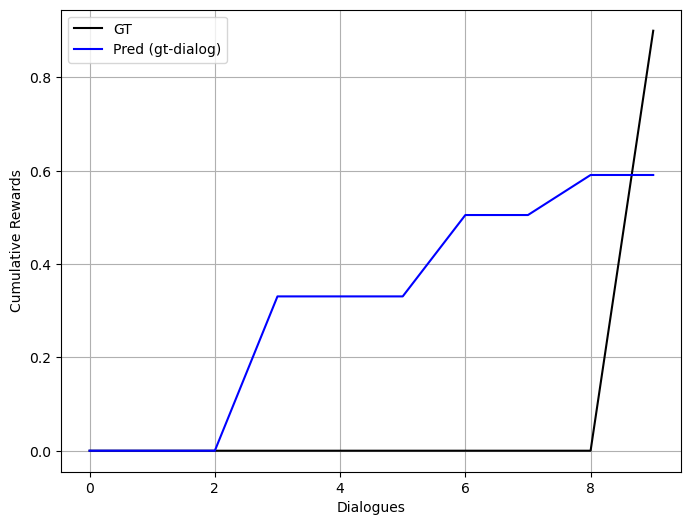

In [74]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 6))
plt.plot(dialog_index_list, gt_list,  color='k', label='GT')
plt.plot(dialog_index_list, pred_ground_truth_list,  color='b', label='Pred (gt-dialog)')

# plt.plot(dialog_index_list, pred_bicogan_list,  color='purple', label='BiCoGAN')
# plt.plot(dialog_index_list, pred_kqr_list,  color='red', label='KQR')

plt.xlabel('Dialogues')
plt.ylabel('Cumulative Rewards')
plt.legend()
plt.grid(True)
plt.show()